In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
# !pip install pycaret
import pycaret


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import pycaret
from pycaret import classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

In [6]:
df = pd.read_csv('mh_updated_v8.csv')

In [7]:
df.head()

,Unnamed: 0.1,Unnamed: 0,No.,self_emp,no_of_emp,is_tech_cmp,is_tech_role,cover_mh,aware_of_mh_cover,mh_emp_discussion,...,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,productivity_measure,days,smoothed_productivity
0,2016-01-01,0,0,0,26-100,1,NaN,Not eligible for coverage / N/A,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0,67.669868
1,2016-01-02,1,1,0,Jun-25,1,NaN,No,Yes,Yes,...,Some of them,Yes,No,Maybe,Yes,No,NaN,37.347140,1,67.669868
2,2016-01-03,2,2,0,Jun-25,1,NaN,No,NaN,No,...,Some of them,No,No,No,Don't know,No,NaN,100.000000,2,67.669868
3,2016-01-04,3,5,0,>1000,1,NaN,Yes,I am not sure,No,...,Yes,Yes,No,Maybe,No,No,NaN,100.000000,3,67.669868
4,2016-01-05,4,6,0,26-100,1,NaN,I don't know,No,No,...,Some of them,Yes,No,No,Don't know,No,NaN,18.169325,4,67.669868


In [8]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'No.', 'self_emp', 'no_of_emp',
       'is_tech_cmp', 'is_tech_role', 'cover_mh', 'aware_of_mh_cover',
       'mh_emp_discussion',
       ...
       'coworkers', 'supervisor', 'mental_health_interview',
       'phys_health_interview', 'mental_vs_physical', 'obs_consequence',
       'comments', 'productivity_measure', 'days', 'smoothed_productivity'],
      dtype='object', length=102)

In [9]:
df.isnull().sum().sort_values(ascending=False)

neg_impact_revealing_mh_colleague          883
med_cov_mh                                 883
experienced_mh_issues                      883
mh_revealed_to_employer_impact             883
mh_revealed_colleague                      883
                                          ... 
mh_look_treatment                            0
mh_good_treatment_impact_workplace_2016      0
mh_bad_treatment_impact_workplace_2016       0
age                                          0
smoothed_productivity                        0
Length: 102, dtype: int64

In [10]:
df.gender.value_counts()

gender
Male      660
Female    203
Others     19
Name: count, dtype: int64

Text(0.5, 1.0, 'Gender distribution')

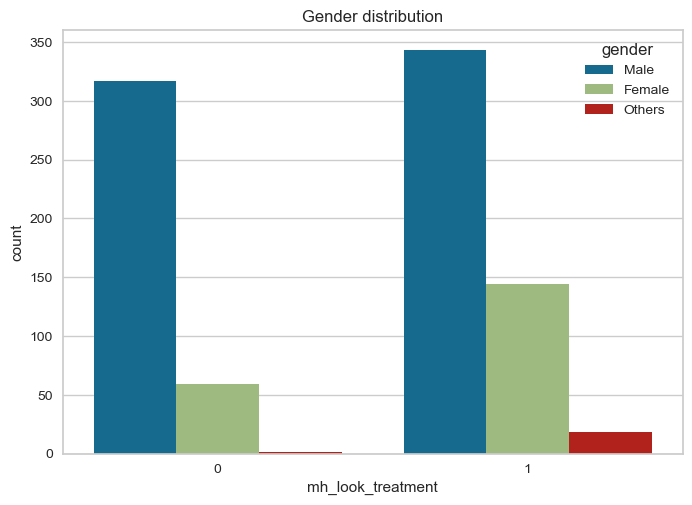

In [11]:
sns.countplot(x= 'mh_look_treatment', data = df, hue = 'gender').set_title('Gender distribution')

<Axes: xlabel='mh_look_treatment', ylabel='count'>

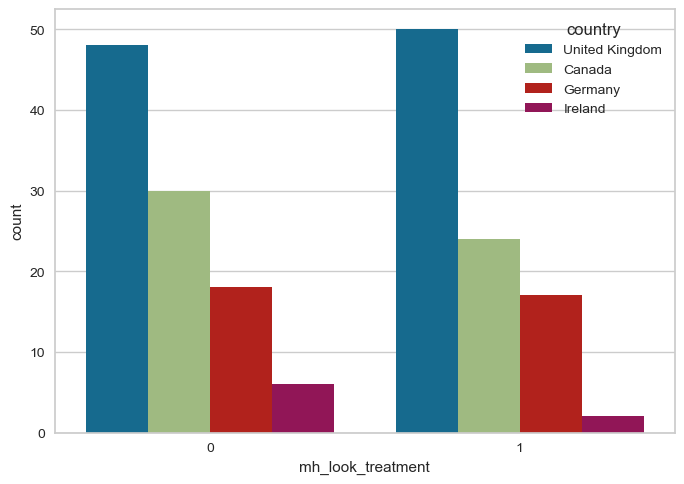

In [12]:
df1 = df[(df.country == 'United States') | (df.country == 'United Kingdom') | (df.country == 'Canada') | (df.country == 'Germany') | (df.country == 'Ireland')]
sns.countplot(x= 'mh_look_treatment', data = df1, hue = 'country')

work_interfere
Sometimes    232
Rarely        85
Often         74
Never         18
Name: count, dtype: int64


Text(0.5, 1.0, 'Does your mental health interfere with work')

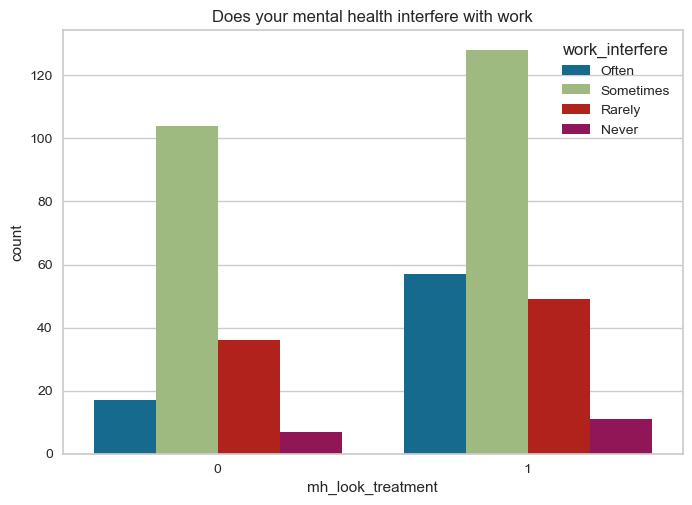

In [13]:
print(df.work_interfere.value_counts())
sns.countplot(x= 'mh_look_treatment', data = df, hue = df.work_interfere).set_title('Does your mental health interfere with work')

In [14]:
df.isnull().sum() #As there are a few number of NA values remaining, let's replace them with 'NA' in order to easily handle them in the next steps
df.work_interfere = df.work_interfere.fillna("NA")
df.self_employed = df.self_employed.fillna("NA")

In [15]:
# Converting strings to numerical values for prediction
toReplace = {
    'Gender' :{'Female': 0, 'Male': 1, 'Other': 2}, 
    'self_employed' :{'No': 0, 'Yes': 1, 'NA': 2}, 
    'mh_family_history' :{'No': 0, 'Yes': 1},
    'mh_look_treatment' :{'No': 0, 'Yes': 1}, 
    'work_interfere' :{'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3, 'NA': 4}, 
    'no_of_emp' :{'6-25': 1, 'More than 1000': 5, '26-100': 2, '100-500': 3, '1-5': 0, '500-1000': 4}, 
    'remote_work' :{'No': 0, 'Yes': 1},
    'benefits' :{'No': 0, 'Yes': 1, "Don't know": 2}, 
    'care_options' :{'No': 0, 'Yes': 1, 'Not sure': 2}, 
    'wellness_program' :{'No': 0, 'Yes': 1, "Don't know": 2},
    'seek_help' :{'No': 0, 'Yes': 1, "Don't know": 2}, 
    'anonymity' :{'No': 0, 'Yes': 1, "Don't know": 2}, 
    'leave' :{'Somewhat easy':2, "Don't know":0, 'Somewhat difficult':3,'Very difficult':4, 'Very easy':1}, 
    'mental_health_consequence' :{'No': 0, 'Yes': 1, 'Maybe': 2},
    'phys_health_consequence' :{'No': 0, 'Yes': 1, 'Maybe': 2}, 
    'coworkers' :{'No': 0, 'Yes': 1, 'Some of them': 2}, 
    'supervisor' :{'No': 0, 'Yes': 1, 'Some of them': 2},
    'mental_health_interview' :{'No': 0, 'Yes': 1, 'Maybe': 2}, 
    'phys_health_interview' :{'No': 0, 'Yes': 1, 'Maybe': 2},
    'mental_vs_physical' :{'No': 0, 'Yes': 1, "Don't know": 2}, 
    'obs_consequence' :{'No': 0, 'Yes': 1},
    'Country': {'United States': 0, 'Canada':1, 'United Kingdom':2, 'Bulgaria':3, 'France':4,'Portugal':5, 'Netherlands':6, 'Switzerland':7, 'Poland':8, 'Australia':9,'Germany':10, 'Russia':11, 'Mexico':12, 'Brazil':13, 'Slovenia':14, 'Costa Rica':15,'Austria':16, 'Ireland':17, 'India':18, 'South Africa':19, 'Italy':20, 'Sweden':21,'Colombia':22, 'Latvia':23, 'Romania':24, 'Belgium':25, 'New Zealand':26, 'Spain':27,'Finland':28, 'Uruguay':29, 'Israel':30, 'Bosnia and Herzegovina':31,'Hungary':32, 'Singapore':33, 'Japan':34, 'Nigeria':35, 'Croatia':36, 'Norway':37,'Thailand':38, 'Denmark':39, 'Bahamas, The':40, 'Greece':41, 'Moldova':42,'Georgia':43, 'China':44, 'Czech Republic':45, 'Philippines':46}
}
df1 = df.replace(toReplace)
df1.head()

,Unnamed: 0.1,Unnamed: 0,No.,self_emp,no_of_emp,is_tech_cmp,is_tech_role,cover_mh,aware_of_mh_cover,mh_emp_discussion,...,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,productivity_measure,days,smoothed_productivity
0,2016-01-01,0,0,0,2,1,NaN,Not eligible for coverage / N/A,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0,67.669868
1,2016-01-02,1,1,0,Jun-25,1,NaN,No,Yes,Yes,...,2.0,1.0,0.0,2.0,1.0,0.0,NaN,37.347140,1,67.669868
2,2016-01-03,2,2,0,Jun-25,1,NaN,No,NaN,No,...,2.0,0.0,0.0,0.0,2.0,0.0,NaN,100.000000,2,67.669868
3,2016-01-04,3,5,0,>1000,1,NaN,Yes,I am not sure,No,...,1.0,1.0,0.0,2.0,0.0,0.0,NaN,100.000000,3,67.669868
4,2016-01-05,4,6,0,2,1,NaN,I don't know,No,No,...,2.0,1.0,0.0,0.0,2.0,0.0,NaN,18.169325,4,67.669868


In [16]:
#Approach 2 - Label Encoding
df2 = df.copy()
df2['Gender'] = df2['Gender'].astype('category').cat.codes
df2['self_employed'] = df2['self_employed'].astype('category').cat.codes
df2['family_history'] = df2['family_history'].astype('category').cat.codes
df2['treatment'] = df2['treatment'].astype('category').cat.codes
df2['work_interfere'] = df2['work_interfere'].astype('category').cat.codes
df2['no_employees'] = df2['no_employees'].astype('category').cat.codes
df2['remote_work'] = df2['remote_work'].astype('category').cat.codes
df2['tech_company'] = df2['tech_company'].astype('category').cat.codes
df2['benefits'] = df2['benefits'].astype('category').cat.codes
df2['care_options'] = df2['care_options'].astype('category').cat.codes
df2['wellness_program'] = df2['wellness_program'].astype('category').cat.codes
df2['seek_help'] = df2['seek_help'].astype('category').cat.codes
df2['anonymity'] = df2['anonymity'].astype('category').cat.codes
df2['leave'] = df2['leave'].astype('category').cat.codes
df2['mental_health_consequence'] = df2['mental_health_consequence'].astype('category').cat.codes
df2['phys_health_consequence'] = df2['phys_health_consequence'].astype('category').cat.codes
df2['coworkers'] = df2['coworkers'].astype('category').cat.codes
df2['supervisor'] = df2['supervisor'].astype('category').cat.codes
df2['mental_health_interview'] = df2['mental_health_interview'].astype('category').cat.codes
df2['phys_health_interview'] = df2['phys_health_interview'].astype('category').cat.codes
df2['mental_vs_physical'] = df2['mental_vs_physical'].astype('category').cat.codes
df2['obs_consequence'] = df2['obs_consequence'].astype('category').cat.codes
df2['Country'] = df2['Country'].astype('category').cat.codes
df2.head()

,Unnamed: 0.1,Unnamed: 0,No.,self_emp,no_of_emp,is_tech_cmp,is_tech_role,cover_mh,aware_of_mh_cover,mh_emp_discussion,...,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,productivity_measure,days,smoothed_productivity
0,2016-01-01,0,0,0,26-100,1,NaN,Not eligible for coverage / N/A,NaN,No,...,-1,-1,-1,-1,-1,-1,NaN,100.000000,0,67.669868
1,2016-01-02,1,1,0,Jun-25,1,NaN,No,Yes,Yes,...,1,2,1,0,2,0,NaN,37.347140,1,67.669868
2,2016-01-03,2,2,0,Jun-25,1,NaN,No,NaN,No,...,1,0,1,1,0,0,NaN,100.000000,2,67.669868
3,2016-01-04,3,5,0,>1000,1,NaN,Yes,I am not sure,No,...,2,2,1,0,1,0,NaN,100.000000,3,67.669868
4,2016-01-05,4,6,0,26-100,1,NaN,I don't know,No,No,...,1,2,1,1,0,0,NaN,18.169325,4,67.669868


In [17]:
df3 = df.copy()
df3 = pd.get_dummies(df3,columns = ['Gender', 'Country', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'])
df3.head()

,Unnamed: 0.1,Unnamed: 0,No.,self_emp,no_of_emp,is_tech_cmp,is_tech_role,cover_mh,aware_of_mh_cover,mh_emp_discussion,...,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes
0,2016-01-01,0,0,0,26-100,1,NaN,Not eligible for coverage / N/A,NaN,No,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-02,1,1,0,Jun-25,1,NaN,No,Yes,Yes,...,True,False,True,False,False,False,False,True,True,False
2,2016-01-03,2,2,0,Jun-25,1,NaN,No,NaN,No,...,True,False,False,True,False,True,False,False,True,False
3,2016-01-04,3,5,0,>1000,1,NaN,Yes,I am not sure,No,...,True,False,True,False,False,False,True,False,True,False
4,2016-01-05,4,6,0,26-100,1,NaN,I don't know,No,No,...,True,False,False,True,False,True,False,False,True,False


In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Columns: 102 entries, Unnamed: 0.1 to smoothed_productivity
dtypes: float64(28), int64(10), object(64)
memory usage: 703.8+ KB


In [19]:
#Approach1
classification_setup1 = classification.setup(data= df1, target='mh_look_treatment')
classification.compare_models()


,Description,Value
0,Session id,3906
1,Target,mh_look_treatment
2,Target type,Binary
3,Original data shape,"(883, 102)"
4,Transformed data shape,"(883, 238)"
5,Transformed train set shape,"(618, 238)"
6,Transformed test set shape,"(265, 238)"
7,Numeric features,37
8,Categorical features,64
9,Rows with missing values,100.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8590,0.9294,0.8784,0.8769,0.8770,0.7119,0.7134,0.3510
lr,Logistic Regression,0.8396,0.9178,0.8755,0.8501,0.8620,0.6704,0.6723,1.3080
nb,Naive Bayes,0.8171,0.8656,0.8361,0.8447,0.8392,0.6270,0.6288,0.2890
et,Extra Trees Classifier,0.8041,0.9240,0.9350,0.7737,0.8456,0.5847,0.6088,0.4130
rf,Random Forest Classifier,0.6878,0.9332,0.9915,0.6523,0.7858,0.2955,0.3981,0.3960
dt,Decision Tree Classifier,0.5728,0.5000,1.0000,0.5728,0.7284,0.0000,0.0000,0.2980
ada,Ada Boost Classifier,0.5728,0.5000,1.0000,0.5728,0.7284,0.0000,0.0000,0.3020
gbc,Gradient Boosting Classifier,0.5728,0.5026,1.0000,0.5728,0.7284,0.0000,0.0000,0.3540
lda,Linear Discriminant Analysis,0.5728,0.5000,1.0000,0.5728,0.7284,0.0000,0.0000,0.3440
lightgbm,Light Gradient Boosting Machine,0.5728,0.5017,1.0000,0.5728,0.7284,0.0000,0.0000,0.4120


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=3906, solver='auto',
                tol=0.0001)

In [20]:
#Approach2
# classification_setup2 = classification.setup(data= df2, target='mh_look_treatment')
# classification.compare_models()
finaldf = df2.copy()
finaldf.head()
X_train, X_test, y_train, y_test = train_test_split(finaldf.drop('mh_look_treatment',axis=1), finaldf['mh_look_treatment'], test_size = 0.25, random_state = 99)

ridge = classification.create_model('ridge')
ridge_tuned = classification.tune_model(ridge)
ridge_tuned.fit(X_train, y_train)
y_pred = ridge_tuned.predict(X_test)
X_test['predicted_mh_look_treatment'] = y_pred

print(X_test.head())

classification.evaluate_model(ridge_tuned)




,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9516,0.9754,0.9722,0.9459,0.9589,0.9001,0.9006
1,0.8387,0.9274,0.8611,0.8611,0.8611,0.6688,0.6688
2,0.8548,0.9338,0.8611,0.8857,0.8732,0.7035,0.7039
3,0.8871,0.9092,0.8611,0.9394,0.8986,0.7718,0.7755
4,0.9355,0.9577,0.9429,0.9429,0.9429,0.8688,0.8688
5,0.9032,0.9640,0.9143,0.9143,0.9143,0.8032,0.8032
6,0.8065,0.8677,0.8857,0.7949,0.8378,0.5996,0.6050
7,0.8065,0.9175,0.8000,0.8485,0.8235,0.6097,0.6109
8,0.7541,0.8791,0.7714,0.7941,0.7826,0.4997,0.5000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9516,0.9872,0.9722,0.9459,0.9589,0.9001,0.9006
1,0.8871,0.9316,0.8611,0.9394,0.8986,0.7718,0.7755
2,0.8710,0.9348,0.8889,0.8889,0.8889,0.7350,0.7350
3,0.8710,0.9252,0.8333,0.9375,0.8824,0.7406,0.7469
4,0.9194,0.9587,0.9143,0.9412,0.9275,0.8367,0.8371
5,0.8871,0.9630,0.8857,0.9118,0.8986,0.7713,0.7718
6,0.8226,0.8857,0.8857,0.8158,0.8493,0.6345,0.6377
7,0.8226,0.9270,0.8000,0.8750,0.8358,0.6437,0.6467
8,0.7869,0.8736,0.7429,0.8667,0.8000,0.5748,0.5826


Fitting 10 folds for each of 10 candidates, totalling 100 fits


ValueError: could not convert string to float: '2016-05-18'

In [ ]:
#Approach3
# How likely employee will look for mental health treatment based on the features
classification_setup3 = classification.setup(data= df3, target='mh_look_treatment')
classification.compare_models()


In [ ]:
df3.to_csv('df3.csv')

In [ ]:
col = df.columns.to_list()

In [ ]:
col
[df3[].to_list()]

In [ ]:
 un = [df3['Unnamed: 0.1'].to_list()]
#   = 'Unnamed: 0',
 no = [df3['No.'].to_list()]
#  self_emp = [df3['self_emp'].to_list()]
 no_of_emp = [df3['no_of_emp'].to_list()],
 is_tech_cmp = [df3['is_tech_cmp'].to_list()]
 is_tech_role = [df3['is_tech_role'].to_list()]
 cover_mh = [df3['cover_mh'].to_list()]
aware_of_mh_cover = [df3['aware_of_mh_cover'].to_list()]
 mh_emp_discussion= [df3['mh_emp_discussion'].to_list()]
 mh_rsrcs = [df3['mh_rsrcs'].to_list()]
 anoymity_prtect = [df3['anoymity_prtect'].to_list()]
 mh_med_leave = [df3['mh_med_leave'].to_list()]
 mh_emp_discussion_neg = [df3['mh_emp_discussion_neg'].to_list()]
 ph_emp_discussion_neg = [df3['ph_emp_discussion_neg'].to_list()]
 mh_colleague_discussion = [df3['mh_colleague_discussion'].to_list()]
 mh_supervisor_discussion = [df3['mh_supervisor_discussion'].to_list()]
 is_mh_seriously = [df3['is_mh_seriously'].to_list()]
 neg_impact_mh_discussion = [df3['neg_impact_mh_discussion'].to_list()]
 med_cov_mh = [df3['med_cov_mh'].to_list()]
 mh_loc_resrcs = [df3['mh_loc_resrcs'].to_list()]
 experienced_mh_issues = [df3['experienced_mh_issues'].to_list()]
 mh_revealed_to_employer_impact = [df3['mh_revealed_to_employer_impact'].to_list()]
 mh_revealed_colleague = [df3['mh_revealed_colleague'].to_list()]
 neg_impact_revealing_mh_colleague = [df3['neg_impact_revealing_mh_colleague'].to_list()]
 mh_affected_prod = [df3['mh_affected_prod'].to_list()]
 how_mh_affected_prod_percent_time = [df3['how_mh_affected_prod_percent_time'].to_list()]
 if_prev_employer = [df3['if_prev_employer'].to_list()]
 mh_benefit_prev_employer = [df3['mh_benefit_prev_employer'].to_list()]
 aware_of_mh_cover_prev_employer = [df3['aware_of_mh_cover_prev_employer'].to_list()]
 mh_discussion_previous_employer =[df3['mh_discussion_previous_employer'].to_list()]
 mh_resrcs_prev_employer = [df3['mh_resrcs_prev_employer'].to_list()]
 anonymity_prtect_prev_employer = [df3['anonymity_prtect_prev_employer'].to_list()]
 mh_prev_employer_discussion_neg = [df3['mh_prev_employer_discussion_neg'].to_list()]
 ph_prev_employer_discussion_neg = [df3['ph_prev_employer_discussion_neg'].to_list()]
 mh_prev_colleagues_discussion = [df3['mh_prev_colleagues_discussion'].to_list()]
 mh_prev_supervisor_discussion = [df3['mh_prev_supervisor_discussion'].to_list()]
 is_mh_seriously_prev_employer = [df3['is_mh_seriously_prev_employer'].to_list()]
 neg_impact_mh_discussion_prev_employer = [df3['neg_impact_mh_discussion_prev_employer'].to_list()]
 discuss_ph_in_interview = [df3['discuss_ph_in_interview'].to_list()]
 discuss_ph_in_interview_why_yes_no = [df3['discuss_ph_in_interview_why_yes_no'].to_list()]
 discuss_mh_in_interview = [df3['discuss_mh_in_interview'].to_list()]
 discuss_mh_in_interview_why_yes_no = [df3['discuss_mh_in_interview_why_yes_no'].to_list()]
 mh_affects_career = [df3['mh_affects_career'].to_list()]
 neg_views_on_mh = [df3['neg_views_on_mh'].to_list()]
 share_mh_family_friends = [df3['share_mh_family_friends'].to_list()]
 experienced_bad_handling_mh_in_workplace = [df3['experienced_bad_handling_mh_in_workplace'].to_list()]
 mh_others_bad_handling = [df3['mh_others_bad_handling'].to_list()]
 mh_family_history = [df3['mh_family_history'].to_list()]
 mh_in_past = [df3['mh_in_past'].to_list()]
 mh_in_present= [df3['mh_in_present'].to_list()]
 what_mh = [df3['what_mh'].to_list()]
 maybe_what_mh = [df3['maybe_what_mh'].to_list()]
 mh_diagnosed_professional = [df3['mh_diagnosed_professional'].to_list()]
 what_mh_diagnosed_by_professional = [df3['what_mh_diagnosed_by_professional'].to_list()]
 mh_look_treatment = [df3['mh_look_treatment'].to_list()]
 mh_good_treatment_impact_workplace_2016 = [df3['mh_good_treatment_impact_workplace_2016'].to_list()]
 mh_bad_treatment_impact_workplace_2016 = [df3['mh_bad_treatment_impact_workplace_2016'].to_list()]
 mh_good_treatment_impact_workplace_2017 = [df3['mh_good_treatment_impact_workplace_2017'].to_list()]
 mh_bad_treatment_impact_workplace_2017 = [df3['mh_bad_treatment_impact_workplace_2017'].to_list()]
 mh_good_treatment_impact_workplace_2018 = [df3['mh_good_treatment_impact_workplace_2018'].to_list()]
 mh_bad_treatment_impact_workplace_2018 = [df3['mh_bad_treatment_impact_workplace_2018'].to_list()]
 mh_good_treatment_impact_workplace_2019 = [df3['mh_good_treatment_impact_workplace_2019'].to_list()]
 mh_bad_treatment_impact_workplace_2019 = [df3['mh_bad_treatment_impact_workplace_2019'].to_list()]
 age = [df3['age'].to_list()]
 gender = [df3['gender'].to_list()]
 country = [df3['country'].to_list()]
 US_state = [df3['US_state'].to_list()]
 work_country = [df3['work_country'].to_list()]
 work_US_state = [df3['work_US_state'].to_list()]
 work_position = [df3['work_position'].to_list()]
 work_remote = [df3['work_remote'].to_list()]
 Timestamp = [df3['Timestamp'].to_list()]
 Age = [df3['Age'].to_list()]
#  Gender = df3['Gender'].to_list()]
#  Country= [df3['Country'].to_list()]
 state = [df3['state'].to_list()]
#  self_employed = [df3['self_employed'].to_list()]
#  family_history = [df3['family_history'].to_list()]
 treatment = [df3['treatment'].to_list()]
#  work_interfere = [df3['work_interfere'].to_list()]
#  no_employees = [df3['no_employees'].to_list()]
#  remote_work = [df3['remote_work'].to_list()]
#  tech_company = [df3['tech_company'].to_list()]
 benefits = [df3["benefits_Don't know"].to_list()]
 care_options = [df3['care_options_No'].to_list()]
 wellness_program = [df3["wellness_program_Don't know"].to_list()]
 seek_help = [df3['seek_help_Yes'].to_list()]
 anonymity = [df3['anonymity_Yes'].to_list()]
 leave = [df3['leave_Very easy'].to_list()]
 mental_health_consequence = [df3['mental_health_consequence_Yes'].to_list()]
 phys_health_consequence = [df3['phys_health_consequence_Yes'].to_list()]
 coworkers = [df3['coworkers_Yes'].to_list()]
 supervisor = [df3['supervisor_Yes'].to_list()]
 mental_health_interview = [df3['mental_health_interview_Yes'].to_list()]
 phys_health_interview = [df3['phys_health_interview_Yes'].to_list()]
 mental_vs_physical = [df3['mental_vs_physical_Yes'].to_list()]
 obs_consequence = [df3['obs_consequence_Yes'].to_list()]
 comments = [df3['comments'].to_list()]
 productivity_measure = [df3['productivity_measure'].to_list()]
 days = [df3['days'].to_list()]
 smoothed_productivity = [df3['smoothed_productivity'].to_list()]

In [ ]:
mh_look_treatment


In [ ]:
dic = {
 col[0]:un,
 col[1]:no,
 col[2]:self_emp,
 col[3]:no_of_emp,
 col[4]:is_tech_cmp,
 col[5]:is_tech_role,
 col[6]:cover_mh,
 col[7]:aware_of_mh_cover,
 col[8]:mh_emp_discussion,
 col[9]:mh_rsrcs,
 col[10]:anoymity_prtect,
 col[11]:mh_med_leave,
 col[12]:mh_emp_discussion_neg,
 col[13]:ph_emp_discussion_neg,
 col[14]:mh_colleague_discussion,
 col[15]:mh_supervisor_discussion,
 col[16]:is_mh_seriously,
 col[17]:neg_impact_mh_discussion,
 col[18]:med_cov_mh,
 col[19]:mh_loc_resrcs,
 col[20]:experienced_mh_issues,
 col[21]:mh_revealed_to_employer_impact,
 col[22]:mh_revealed_colleague,
 col[23]:neg_impact_revealing_mh_colleague,
 col[24]:mh_affected_prod,
 col[25]:how_mh_affected_prod_percent_time,
 col[26]:if_prev_employer,
 col[27]:mh_benefit_prev_employer,
 col[28]:aware_of_mh_cover_prev_employer,
 col[29]:mh_discussion_previous_employer,
 col[30]:mh_resrcs_prev_employer,
 col[31]:anonymity_prtect_prev_employer,
 col[32]:mh_prev_employer_discussion_neg,
 col[33]:ph_prev_employer_discussion_neg,
 col[34]:mh_prev_colleagues_discussion,
 col[35]:mh_prev_supervisor_discussion,
 col[36]:is_mh_seriously_prev_employer,
 col[37]:neg_impact_mh_discussion_prev_employer,
 col[38]:discuss_ph_in_interview,
 col[39]:discuss_ph_in_interview_why_yes_no,
 col[40]:discuss_mh_in_interview,
 col[41]:discuss_mh_in_interview_why_yes_no,
 col[42]:mh_affects_career,
 col[43]:neg_views_on_mh,
 col[44]:share_mh_family_friends,
 col[45]:experienced_bad_handling_mh_in_workplace,
 col[46]:mh_others_bad_handling,
 col[47]:mh_family_history,
 col[48]:mh_in_past,
 col[49]:mh_in_present,
 col[50]:what_mh,
 col[51]:maybe_what_mh,
 col[52]:mh_diagnosed_professional,
 col[53]:what_mh_diagnosed_by_professional,
 col[54]:mh_look_treatment,
 col[55]:mh_good_treatment_impact_workplace_2016,
 col[56]:mh_bad_treatment_impact_workplace_2016,
 col[57]:mh_good_treatment_impact_workplace_2017,
 col[58]:mh_bad_treatment_impact_workplace_2017,
 col[59]:mh_good_treatment_impact_workplace_2018,
 col[60]:mh_bad_treatment_impact_workplace_2018,
 col[61]:mh_good_treatment_impact_workplace_2019,
 col[62]:mh_bad_treatment_impact_workplace_2019,
 col[63]:age,
 col[64]:gender,
 col[65]:country,
 col[66]:US_state,
 col[67]:work_country,
 col[68]:work_US_state,
 col[69]:work_position,
 col[70]:work_remote,
 col[71]:Timestamp,
 col[72]:Age,
 col[73]:state,
 col[74]:treatment,
 col[75]:benefits,
 col[76]:care_options,
 col[77]:wellness_program,
 col[78]:seek_help,
 col[79]:anonymity,
 col[80]:leave,
 col[81]:mental_health_consequence,
 col[82]:phys_health_consequence,
 col[83]:coworkers,
 col[84]:supervisor,
 col[85]:mental_health_interview,
 col[86]:phys_health_interview,
 col[87]:mental_vs_physical,
 col[88]:obs_consequence,
 col[89]:comments,
 col[90]:productivity_measure,
 col[91]:days,
 col[92]:smoothed_productivity}

In [ ]:
df4 = pd.DataFrame(dic)
df4

In [ ]:
df4.to_excel('new.xlsx')

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming df2 is your original DataFrame with mixed data types

# Example preprocessing steps
# Replace with your actual preprocessing steps based on your data

# Drop non-numeric columns if not needed or handle them appropriately
finaldf_numeric = finaldf.select_dtypes(include=['number'])

# Split data into features and target
X = finaldf_numeric.drop('mh_look_treatment', axis=1)
y = finaldf_numeric['mh_look_treatment']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)

# Example of preprocessing pipeline
numeric_features = X_train.columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
        # Add more transformers for categorical data if needed
    ])

# Apply preprocessing pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Create and tune Ridge Classifier model
ridge = classification.create_model('ridge')
ridge_tuned = classification.tune_model(ridge)

# Fit model on preprocessed training data
ridge_tuned.fit(X_train_processed, y_train)

# Predict values on the preprocessed test set
y_pred = ridge_tuned.predict(X_test_processed)

# Add predicted values to the test set dataframe
X_test['predicted_mh_look_treatment'] = y_pred

# Display the updated dataframe
print(X_test.head())



In [ ]:
from sklearn.impute import SimpleImputer

# Identify NaN values in X_train_processed and X_test_processed
print("NaN values in X_train_processed:", np.isnan(X_train_processed).sum())
print("NaN values in X_test_processed:", np.isnan(X_test_processed).sum())

# Impute NaN values with mean (you can choose another strategy based on your data)
imputer = SimpleImputer(strategy='mean')
X_train_processed_imputed = imputer.fit_transform(X_train_processed)
X_test_processed_imputed = imputer.transform(X_test_processed)

# Create and tune Ridge Classifier model
ridge = classification.create_model('ridge')
ridge_tuned = classification.tune_model(ridge)

# Fit model on preprocessed training data with imputed NaN values
ridge_tuned.fit(X_train_processed_imputed, y_train)

# Predict values on the preprocessed test set with imputed NaN values
y_pred = ridge_tuned.predict(X_test_processed_imputed)

# Add predicted values to the test set dataframe
X_test['predicted_mh_look_treatment'] = y_pred

# Display the updated dataframe
print(X_test.head())


In [ ]:
X_test.head()

In [ ]:
X_test.to_csv('predicted_values.csv')

In [ ]:
df2.to_csv('new_df.csv')

In [21]:
coef = ridge.coef_

In [22]:
coef

array([[ 4.61406073e+00,  1.25925163e-03, -1.55695508e-03,
         0.00000000e+00, -2.19292532e-03,  3.66092604e-02,
         8.05504776e-03, -2.22290940e-02,  3.09342773e-02,
        -5.11765661e-02,  0.00000000e+00, -5.36938289e-03,
         1.26331342e-02, -2.24826750e-02,  1.52189237e-02,
        -2.38539710e-02,  1.78381356e-03,  2.20701575e-02,
         1.05106084e-02,  1.12333703e-02, -8.74627225e-02,
         6.57187438e-02, -4.61279756e-02, -2.21500665e-03,
         4.83429823e-02, -1.61711153e-02,  1.54578716e-02,
         7.13243680e-04, -1.37370767e-02,  2.23089592e-02,
        -8.57188242e-03, -3.93434993e-02,  3.05665753e-03,
         3.62868417e-02, -1.06724568e-01,  2.47750740e-02,
        -4.21130986e-02, -1.41877155e-03,  3.54946793e-02,
         8.99866843e-02, -4.27063726e-02, -5.28628105e-02,
         9.55691831e-02, -4.01254191e-02, -8.00839897e-04,
         4.09262590e-02,  7.08295346e-03, -1.08263988e-02,
         3.74344533e-03, -1.48484072e-02, -5.37863152e-0